### Design the State Variables 6

For our robot we will maintain the position and orientation:

$$\mathbf x = \begin{bmatrix}x & \dot x & y & \dot y & \theta & \dot \theta\end{bmatrix}^\mathsf{T}$$


The control input $\mathbf{u}$ is the commanded linear velocity and the commanded angular velocity 

$$\mathbf{u} = \begin{bmatrix}v & \omega\end{bmatrix}^\mathsf{T}$$

In [1]:
from math import tan, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
from numpy.random import normal, randn
import numpy as np
from numpy.random import multivariate_normal
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

def move(x, dt, u):
    hdg : float= x[4]

    #x_ = u[0] * cos(hdg) * dt
    x[1]=u[0] * cos(hdg)
    #y = u[0] * sin(hdg) * dt  
    x[3] = u[0] * sin(hdg) 
    #theta = u[1]*dt
    x[5]=u[1]
    x[0],x[2],x[4]=runge_kutta([x[0],x[2],x[4]],u,dt)
    return x #+ np.array([x_,0,y,0,theta,0])

def kinematic_model(state, control, dt):
    x, y, theta = state
    v, omega = control

    # Derivate del sistema
    dx = v * cos(theta)
    dy = v * sin(theta)
    dtheta = omega

    return np.array([dx, dy, dtheta])

def runge_kutta(state, control, dt):
    k1 = kinematic_model(state, control, dt)
    k2 = kinematic_model(state + 0.5 * dt * k1, control, dt)
    k3 = kinematic_model(state + 0.5 * dt * k2, control, dt)
    k4 = kinematic_model(state + dt * k3, control, dt)

    new_state = state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return new_state


def residual_h(a, b):
    y = a - b
    return y

def residual_x(a, b):
    y = a - b
    return y

def state_mean(sigmas, Wm):
    x = np.zeros(6)
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = np.sum(np.dot(sigmas[:, 2], Wm))
    x[3] = np.sum(np.dot(sigmas[:, 3], Wm))
    x[4] = np.sum(np.dot(sigmas[:, 4], Wm))
    x[5] = np.sum(np.dot(sigmas[:, 5], Wm))
    return x

def z_mean(sigmas, Wm):
    z_count = sigmas.shape[1]
    x = np.zeros(z_count)
    x[0] = np.sum(np.dot(sigmas[:,0], Wm))
    x[1] = np.sum(np.dot(sigmas[:,1], Wm))
    return x


We can now implement the measurement model. The equation is
$$h(\mathbf x, \mathbf P)
= \begin{bmatrix}
v \\
\omega 
\end{bmatrix} =
\begin{bmatrix}
\dfrac{\dot x} {\cos(\theta)}\\
\dot \theta 
\end{bmatrix}$$

The angle $\theta$ is in radiant so we don't have to normalize the variable.

In [2]:
def Hx(x):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    v=sqrt(x[1]**2+x[3]**2) 
    w=x[5]
    return np.array([v,w])

Here we define our simulation, this funcion run both the virtual differential drive, using the move funtion, both the UKF with the predict and update function from the filterpy library.

In [3]:
from filterpy.stats import plot_covariance
from filterpy.common import Q_discrete_white_noise
from scipy.linalg import block_diag

dt = 0.1
proc_noise_vr=0.02

def run_localization(
    cmds, sigma_v, sigma_w, ellipse_step=1, step=10):

    plt.figure()
    points = MerweScaledSigmaPoints(n=6, alpha=.00001, beta=2, kappa=0, 
                                    subtract=residual_x)
    ukf = UKF(dim_x=6, dim_z=2, fx=move, hx=Hx,
              dt=dt, points=points, x_mean_fn=state_mean, 
              z_mean_fn=z_mean, residual_x=residual_x, 
              residual_z=residual_h)

    ukf.x = np.array([10,0,10,0,0.1,0])
    ukf.P = np.diag([.01,.01,.01,.01,.005,.005])
    ukf.R = np.diag([sigma_v**2,sigma_w**2])
    ukf.Q = block_diag(Q_discrete_white_noise(2, dt=dt, var=proc_noise_vr),
                       Q_discrete_white_noise(2, dt=dt, var=proc_noise_vr),
                       Q_discrete_white_noise(2, dt=dt, var=proc_noise_vr))
    
    sim_pos = ukf.x.copy()
    
    
    track = []

    for i, u in enumerate(cmds):   
        print("Pos ",i,":",sim_pos)
        #print("Pos sim ",i,":",ukf.x)
        sim_pos = move(sim_pos, dt/step, u)# + np.array([randn(),0,randn(),0,randn(),0])*proc_noise_vr
        track.append(list(sim_pos))

        if i % step == 0:
            ukf.predict(u=u)
            if i % ellipse_step == 0:
                cov =np.diag([ukf.P[0,0],ukf.P[2,2]])
                cov[0,1]=ukf.P[0,2]
                cov[1,0]=ukf.P[2,0]
                plot_covariance((ukf.x[0], ukf.x[2]), cov,facecolor='k', alpha=0.3)
            z = Hx(sim_pos)
            z[0] += randn() * sigma_v
            z[1] += randn() * sigma_w            
            ukf.update(z)

            if i % ellipse_step == 0:
                #print(ukf.P[0,0])
                cov =np.diag([ukf.P[0,0],ukf.P[2,2]])
                cov[0,1]=ukf.P[0,2]
                cov[1,0]=ukf.P[2,0]
                #print(cov)
                plot_covariance((ukf.x[0], ukf.x[2]), cov=cov,facecolor='g', alpha=0.8)
    
    track = np.array(track)
    
    plt.plot(track[:, 0], track[:,2], color='k', lw=2)
    plt.axis('equal')
    plt.title("UKF Robot localization x-y")
    plt.show()
    return ukf

### Design the State Variables 9 

For our robot we will maintain the position and orientation and we added the angular acceleration and both linear velocity and acceleration :

$$\mathbf x = \begin{bmatrix}x & \dot x & y & \dot y & \theta & \dot \theta & \ddot \theta & v & \dot v\end{bmatrix}^\mathsf{T}$$


The control input $\mathbf{u}$ is the commanded linear velocity and the commanded angular velocity, the same as before: 

$$\mathbf{u} = \begin{bmatrix} v & \omega \end{bmatrix}^\mathsf{T}$$

In [4]:
from math import sin, cos
import matplotlib.pyplot as plt
from numpy.random import randn
import numpy as np
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

def move(x, dt, u):
    hdg = x[4]
    x[6]=(x[5]-u[1])/dt
    x[8]=(x[7]-u[0])/dt
    x[5]=u[1]
    x[7]=u[0]
    #x_ = u[0] * cos(hdg) * dt
    x[1]=x[7] * cos(hdg)
    #y = u[0] * sin(hdg) * dt  
    x[3] =x[7] * sin(hdg) 
    #theta = u[1]*dt
    x[0],x[2],x[4]=runge_kutta([x[0],x[2],x[4]],[x[7],x[5]],dt)

    return x #+ np.array([x_,0,y,0,theta,0])

def move_real(x, dt, u,v_std,w_std):
    u_real=np.zeros(2)
    u_real[0] = u[0] + randn()*v_std
    u_real[1] = u[1] + randn()*0.03
    hdg = x[4]
    x[6]=(x[5]-u[1])/dt
    x[8]=(x[7]-u[0])/dt
    x[5]=u_real[1]
    x[7]=u_real[0]
    #x_ = u[0] * cos(hdg) * dt
    x[1]=x[7] * cos(hdg)
    #y = u[0] * sin(hdg) * dt  
    x[3] =x[7] * sin(hdg) 
    #theta = u[1]*dt
    x[0],x[2],x[4]=runge_kutta([x[0],x[2],x[4]],[x[7],x[5]],dt)

    return x #+ np.array([x_,0,y,0,theta,0])

def kinematic_model(state, control, dt):
    x, y, theta = state
    v, omega = control

    # Derivate del sistema
    dx = v * cos(theta)
    dy = v * sin(theta)
    dtheta = omega

    return np.array([dx, dy, dtheta])

def runge_kutta(state, control, dt):
    k1 = kinematic_model(state, control, dt)
    k2 = kinematic_model(state + 0.5 * dt * k1, control, dt)
    k3 = kinematic_model(state + 0.5 * dt * k2, control, dt)
    k4 = kinematic_model(state + dt * k3, control, dt)

    new_state = state + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return new_state

def residual_h(a, b):
    y = a - b
    return y

def residual_x(a, b):
    y = a - b
    return y

def state_mean(sigmas, Wm):
    x = np.zeros(9)
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = np.sum(np.dot(sigmas[:, 2], Wm))
    x[3] = np.sum(np.dot(sigmas[:, 3], Wm))
    x[4] = np.sum(np.dot(sigmas[:, 4], Wm))
    x[5] = np.sum(np.dot(sigmas[:, 5], Wm))
    x[6] = np.sum(np.dot(sigmas[:, 6], Wm))
    x[7] = np.sum(np.dot(sigmas[:, 7], Wm))
    x[8] = np.sum(np.dot(sigmas[:, 8], Wm))
    return x

def z_mean(sigmas, Wm):
    z_count = sigmas.shape[1]
    x = np.zeros(z_count)
    x[0] = np.sum(np.dot(sigmas[:,0], Wm))
    x[1] = np.sum(np.dot(sigmas[:,1], Wm))
    return x


We can now implement the measurement model. The equation is
$$h(\mathbf x, \mathbf P)
= \begin{bmatrix}
\dot v \\
\dot \omega 
\end{bmatrix} =
\begin{bmatrix}
x[8]\\
x[6] 
\end{bmatrix}$$

The angle $\theta$ is in radiant so we don't have to normalize the variable.

In [5]:
def Hx(x):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    v_dot=x[8] 
    w_dot=x[6]
    return np.array([v_dot,w_dot])

Here we define our simulation, this funcion run both the virtual differential drive, using the move funtion, both the UKF with the predict and update function from the filterpy library.

In [6]:
from filterpy.stats import plot_covariance
from filterpy.common import Q_discrete_white_noise
from scipy.linalg import block_diag

def run_localization(cmds, sigma_v_dot, sigma_w_dot, init_err=[0,0,0,0,0,0,0,0,0], proc_noise_vr=0.02, ellipse_step=1, step=10,dt = 0.5):

    #Point definition for non linear problem
    points = MerweScaledSigmaPoints(n=9, alpha=.00001, beta=2, kappa=0, subtract=residual_x)
    
    #UKF parameter 
    ukf = UKF(dim_x=9, dim_z=2, fx=move, hx=Hx,
              dt=dt, points=points, x_mean_fn=state_mean, 
              z_mean_fn=z_mean, residual_x=residual_x, 
              residual_z=residual_h)

    ukf.x = np.array([10,0,10,0,0.1,0,0,0,0])
    ukf.P = np.diag([.01,.01,.01,.01,.005,.005,.005,.005,.005])
    ukf.R = np.diag([sigma_v_dot**2,sigma_w_dot**2])
    ukf.Q = block_diag(Q_discrete_white_noise(2, dt=dt, var=proc_noise_vr),
                       Q_discrete_white_noise(2, dt=dt, var=proc_noise_vr),
                       Q_discrete_white_noise(3, dt=dt, var=proc_noise_vr),
                       Q_discrete_white_noise(2, dt=dt, var=proc_noise_vr))
    
    # auxiliary variable
    sim_pos = ukf.x.copy() + np.array(init_err)
    track = []

    plt.figure()
    for i, u in enumerate(cmds):   
        #print("Pos ",i,":",sim_pos)
        #print("Pos sim ",i,":",ukf.x)
        
        # Simulation step with a dt of dt/step, standard value 0.05
        sim_pos = move_real(sim_pos, dt/step, u, sigma_v_dot ,sigma_w_dot)
        track.append(list(sim_pos))

        # UKF step every variable(step) cicle, every variable(dt) seconds
        if i % step == 0:
            
            ukf.predict(u=u)
            if i % ellipse_step == 0:
                cov =np.diag([ukf.P[0,0],ukf.P[2,2]])
                cov[0,1]=ukf.P[0,2]
                cov[1,0]=ukf.P[2,0]
                plot_covariance((ukf.x[0], ukf.x[2]), cov,facecolor='r', alpha=0.8)
            
            # Sensor mesurement
            z = Hx(sim_pos)
            z[0] += randn() * sigma_v_dot
            z[1] += randn() * sigma_w_dot   
             
            ukf.update(z)

            if (i) % ellipse_step == 0:
                cov =np.diag([ukf.P[0,0],ukf.P[2,2]])
                cov[0,1]=ukf.P[0,2]
                cov[1,0]=ukf.P[2,0]
                plot_covariance((ukf.x[0], ukf.x[2]), cov=cov,facecolor='g', alpha=0.8) 
    
    
    track = np.array(track)
    plt.plot(track[:, 0], track[:,2], color='k', lw=2)
    plt.axis('equal')
    plt.title("UKF Robot localization x-y")
    plt.show()
    return ukf

Let's run a simple simulation with a veri linear path:

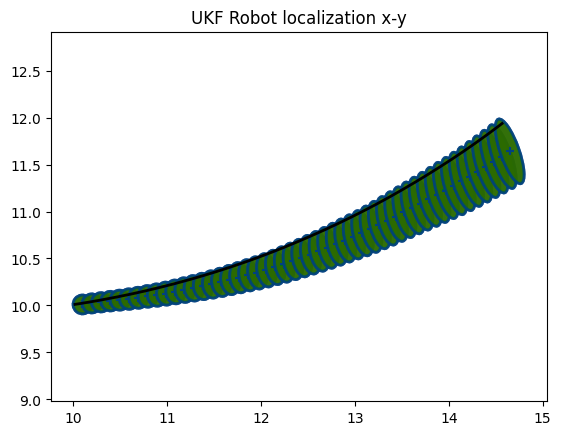

Final P: [2.35786418e-02 1.73238832e-03 1.18682440e-01 3.68832651e-03
 5.00866671e-03 2.00000000e-04 2.66666667e-02 5.00003638e-07
 2.33333495e-04]


In [7]:
cmds = [np.array([1, 0.1])] * 500
ukf = run_localization(cmds,init_err=[0.01,0,0.01,0,0.05,0,0,0,0], sigma_w_dot=0.1, sigma_v_dot=0.01, dt=0.1, step= 10)
print('Final P:', ukf.P.diagonal())

In [8]:
# accelerate from a stop
cmds = [[v, .0] for v in np.linspace(0.001, 1.1, 30)]
cmds.extend([cmds[-1]]*50)

# turn left
v = cmds[-1][0]
cmds.extend([np.array([v, .1])]*100)

#turn right
cmds.extend([np.array([v,-.1])]*100)
cmds.extend([cmds[-1]]*100)
#print(cmds)


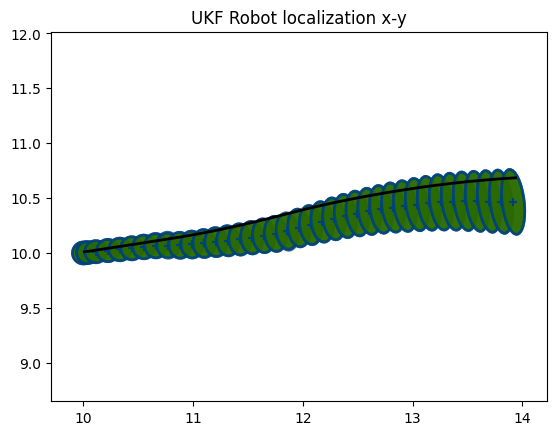

final covariance [1.11299329e-02 2.16119804e-04 8.70533545e-02 6.24913947e-03
 5.00059204e-03 2.00000000e-04 2.00995025e-02 5.00009313e-07
 2.49752166e-04]


In [9]:
ukf = run_localization(cmds,init_err=[0.01,0,0.01,0,0.05,0,0,0,0], sigma_v_dot=0.1, sigma_w_dot=0.01, dt=0.1, step=10, ellipse_step=5)
print('final covariance', ukf.P.diagonal())